# Gradients from mvlearn
Instead of GCCA, we try the mostly equivalent GroupPCA and MCCA

In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from mvlearn.embed import MCCA, GCCA, utils
from mvlearn.decomposition import GroupPCA
from pathlib import Path
import pandas as pd
from collections import defaultdict, OrderedDict
import os
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
## Returns files that match a query from a folder. Keeps names but not file endings
def get_files(path, ftype='csv'):
    query = f'.*\.{ftype}'
    files = [f[:-len(ftype)] for f in os.listdir(path) if re.search(query, f)]
    return files

## Reads the data from each file
def read_file(path):
    return(pd.read_csv(path, header = None).to_numpy())

In [3]:
## Define paths to data
basedir = Path('/mnt/ssd3/ronan/data')
datadir = basedir / 'raw'

In [4]:
ftype = 'csv'
filenames = get_files(path=datadir, ftype=ftype)

## Scree plot and dimension selection

In [5]:
def preproccess(X):
    X -= X.mean(1, keepdims=True)
    X /= X.std(1, keepdims=True)
    return X

In [6]:
level='(e|n)'
subject='([0-9]{3})'
task='(.+?)'

query = f'^{level}_sub-'
query += f'{subject}_ses-1_'
query += f'task-{task}\.'

regex_matches = []
for f in filenames:
    match = re.search(query, f)
    regex_matches.append(match.groups())

In [7]:
# dict -> [idx_resting, idx_compassion, idx_om]
state_list = ['Resting', 'Compassion', 'Open monitoring']
state_dict = {
    'restingstate': 0,
    'compassion': 1,
    'openmonitoring': 2,
}
subj2idx_dict = defaultdict(lambda: np.zeros(3).astype(int))
trait2subj_dict = {'n': set(), 'e': set()}
for i, (trait, subj_id, state) in enumerate(regex_matches):
    subj2idx_dict[subj_id][state_dict[state]] = i
    trait2subj_dict[trait].add(subj_id)

In [9]:
svals_path = '../data/intermediates/singular_values_all.npy'
if not ('svals_mat' in locals() or 'svals_mat' in globals()):
    try:
        svals_mat = np.load(svals_path, allow_pickle=True)
    except FileNotFoundError:
        print('Making new file')
        svals_mat = []
        for i, (trait, subj_id, state) in enumerate(regex_matches):
            X = read_file(datadir / f'{filenames[i]}{ftype}')
            X = preproccess(X)
            _, s, _ = svds(X, k = int(np.ceil(np.log2(np.min(X.shape)))))
            del X
            s = np.sort(s)[::-1] # Descending
            svals_mat.append(s)
        try:
            # Deprecation soon, specify 'dtype=object' in the future
            svals_mat = np.asarray(svals_mat)
            np.save(svals_path, svals_mat)
        except:
            # Turns out don't need this.
            save_dict = OrderedDict({
                i: svals for i, svals in enumerate(svals_mat)
            })
            with open(svals_path, 'wb') as fp:
                pickle.dump(save_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
[s.shape for s in svals_mat]

[(9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (8,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (8,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (8,),
 (9,),
 (9,),
 (8,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (9,),
 (8,),

In [24]:
elbows = []
n_elbows = 3
for s in svals_mat:
    els, _ = utils.select_dimension(s, n_elbows=n_elbows)
    elbows.append(els)
elbows = np.asarray(elbows)

In [25]:
np.min(elbows, axis=0)

array([1, 2, 3])

In [27]:
np.max(elbows, axis=0)

array([4, 7, 9])

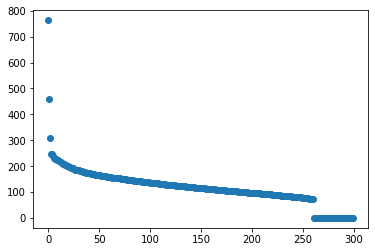

In [51]:
plt.scatter(np.arange(300), svals_mat[3])

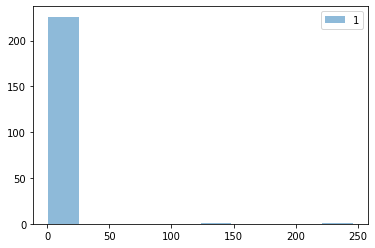

In [43]:
for i in range(n_elbows):
    plt.hist(elbows[:, i], label=i+1, alpha=1/n_elbows)
    break
plt.legend()
plt.show()

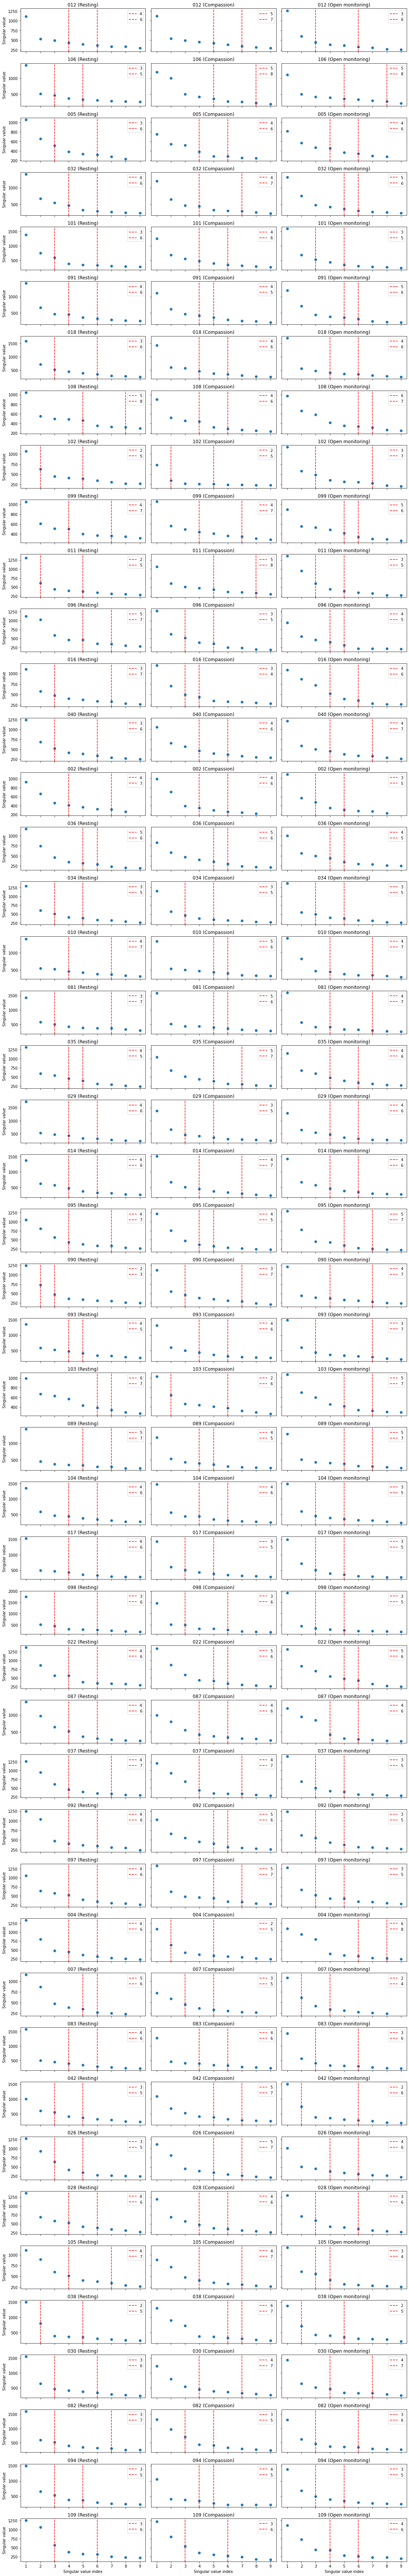

In [26]:
trait = 'n'
subjs = list(trait2subj_dict[trait])
fig, axes = plt.subplots(len(subjs), 3, sharex=True, sharey='row', figsize=(15, len(subjs)*2))
for row, subj in enumerate(subjs):
    for col, idx in enumerate(subj2idx_dict[subj]):
        s = svals_mat[subj2idx_dict[subj][col]]
        (elbow1, elbow2, elbow3), _ = utils.select_dimension(s, n_elbows=3)

        ax = axes[row, col]
        ax.scatter(np.arange(1, len(s)+1), s)
        for elbow in [elbow2, elbow3]:
            ax.axvline(elbow, c='r', ls='--', label=f'{elbow}')
        if row == len(subjs) - 1:
            axes[row, col].set_xlabel('Singular value index')
        ax.set_title(f'{subj} ({state_list[col]})')
        ax.legend(loc='upper right')
    axes[row, 0].set_ylabel('Singular value')
fig.tight_layout()
# plt.savefig('../reports/data_exploration/novice_screeplots.pdf')
plt.show()

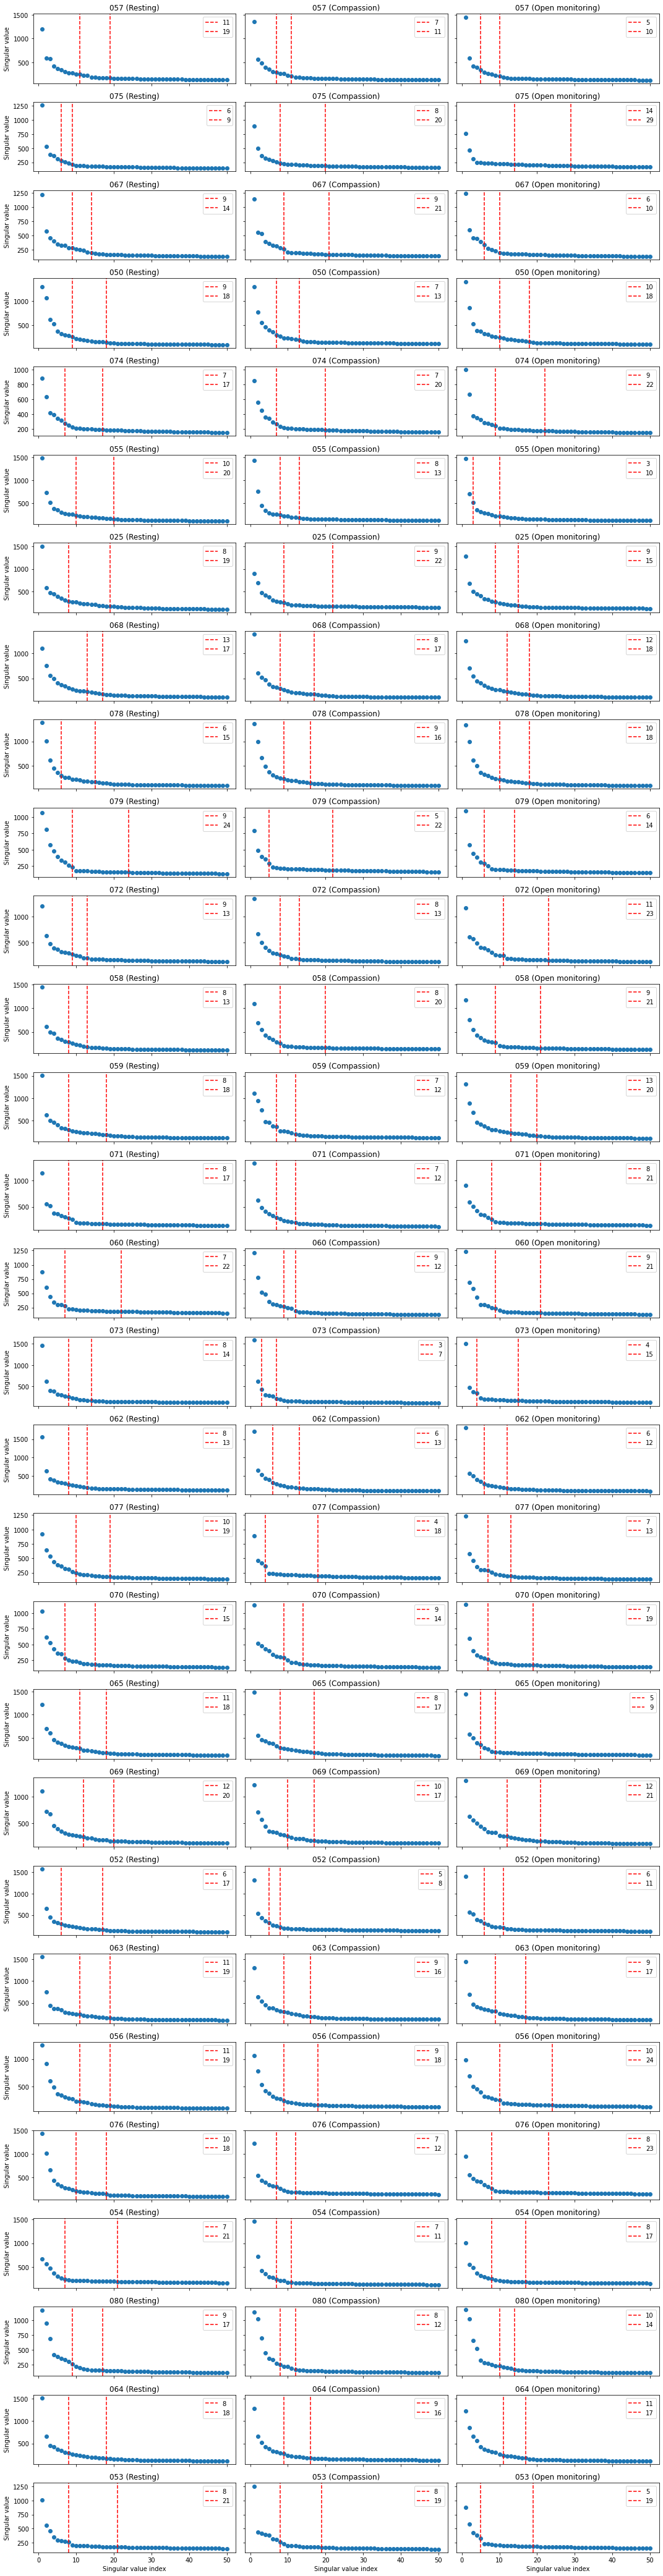

In [60]:
trait = 'e'
subjs = list(trait2subj_dict[trait])
fig, axes = plt.subplots(len(subjs), 3, sharex=True, sharey='row', figsize=(15, len(subjs)*2))
for row, subj in enumerate(subjs):
    for col, idx in enumerate(subj2idx_dict[subj]):
        s = svals_mat[subj2idx_dict[subj][col]]
        (elbow1, elbow2, elbow3), _ = utils.select_dimension(s, n_elbows=3)

        ax = axes[row, col]
        ax.scatter(np.arange(1, len(s)+1), s)
        for elbow in [elbow2, elbow3]:
            ax.axvline(elbow, c='r', ls='--', label=f'{elbow}')
        if row == len(subjs) - 1:
            axes[row, col].set_xlabel('Singular value index')
        ax.set_title(f'{subj} ({state_list[col]})')
        ax.legend(loc='upper right')
    axes[row, 0].set_ylabel('Singular value')
fig.tight_layout()
plt.savefig('../reports/data_exploration/expert_screeplots.pdf')
plt.show()

## Load data and compute elbows

In [18]:
elbows1 = []
elbows2 = []
# elbows3 = []
for s in svals_mat:
    (elbow1, elbow2), _ = utils.select_dimension(s, n_elbows=2)
    elbows1.append(elbow1)
    elbows2.append(elbow2)
    # elbows3.append(elbow3)

In [22]:
min(elbows2)

3

In [62]:
Xs = []
for file in filenames:
    X = read_file(datadir / f'{filenames[i]}{ftype}')
    X = preproccess(X)
    Xs.append(X)
    del X

## GroupPCA embeddings

In [64]:
gpca = GroupPCA(n_components=3, n_individual_components=elbows2)
Xs_gpca = gpca.fit_transform(Xs)

In [66]:
Xs_gpca = np.asarray(Xs_gpca)

In [68]:
np.linalg.norm(Xs_gpca[0], axis=0)

array([9214.20937057, 7681.34564615, 6743.07128163])

## iMCCA embeddings

In [70]:
mcca = MCCA(n_components=3, signal_ranks=elbows2)
Xs_mcca = mcca.fit_transform(Xs)

In [73]:
np.linalg.norm(Xs_mcca[0], axis=0)

array([0.06622662, 0.06622662, 0.06622662])

## Test normalization

In [79]:
X = np.random.normal(0, 1, (10, 3))

In [118]:
A_mA = X - X.mean(1)[:,None]
ssA = (A_mA**2).sum(1)
Asq = np.sqrt(np.dot(ssA[:,None],ssA[None]))
Adot = A_mA.dot(A_mA.T)

K = Adot/Asq

norm = (K * K).sum(0, keepdims=True) ** .5
K = K.T @ K
K = K / norm / norm.T

In [119]:
u, s, vt = svds(K, k=2)
print(np.sqrt(s))

[1.71349038 2.65780939]


In [120]:
K = X - X.mean(1, keepdims=True)
K /= K.std(1, keepdims=True)

u, s, vt = svds(K, k=2)
print(s)

[3.18279542 4.45755688]
